# Comparison Notebook

Here we'll take a look at stars from other literature, and assign our own membership probabilities to them. We'll also plot them to assess some common characteristics between the stars the process keeps or rejects.

**Note:** most of the naming will have to be readjusted when analyzing a new cluster. 

In [1]:
# General imports
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.patches import Circle, Rectangle

# Crossmatching with other catalogs
from astroquery.vizier import Vizier
from collections import defaultdict

# 1. Data import and merging

In [2]:
# Import the stars with probabilities, generated in notebook 3
observed_probs_df = pd.read_csv('C:/Users/smick/Desktop/Research/notebooks/piecewise/observed_stars_probabilities.csv')

# Import Gala stars to see where cluster stars are predicted to be
gala_stars = pd.read_csv('C:/Users/smick/Desktop/Research/notebooks/piecewise/gala_stars.csv')

# Import members/matches/targets 
Johnson_matches = pd.read_csv('C:/Users/smick/Desktop/Research/data/johnson_bdbs_match.csv')
Hughes_targets = pd.read_csv('C:/Users/smick/Desktop/Research/data/N6569spectra_all_121124.csv')

# Check column naming
print(Johnson_matches.columns.tolist())
print(Hughes_targets.columns.tolist())

['ra1', 'ra2', 'ra3', '1-Dec', '2-Dec', '3-Dec', '2massID', 'VVVID', 'VLTname', 'EW_8542A', 'EW_8662A', 'sumEWCaII', 'WK', 'FeH', 'errFeH', 'feh', 'RV', 'RAdeg', 'DECdeg', 'Dimag', 'Wd', 'FeHCaT', 'FeH_l', 'FeH_h', 'DF', 'Fe', 'n6569_oid', 'radeg', 'decdeg', 'umag', 'uerr', 'gmag', 'gerr', 'rmag', 'rerr', 'imag', 'ierr', 'zmag', 'zerr', 'ymag', 'yerr', 'Au', 'Ag', 'Ar', 'Ai', 'Az', 'Ay', 'bdbs_id', 'gaia_id', 'source_id', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'phot_g_mean_mag', 'Separation', 'i0', 'iHB0', 'FeHi0', 'FeHagain', 'iHB', 'FeHi', 'Wi30', 'Wi3', 'Wfit', 'FeHfit0', 'Dfit', 'aDfit']
['ID', 'aFe_av', 'e_aFe', '[m/H]', '[Fe/H]', 'Fe_av', 'e_Fe', 'M_av', 'e_M', 'T', 'e_T', 'logg_av', 'e_logg', 'ra', 'dec', 'plx', 'e_plx', 'pmra', 'e_pmra', 'pmdec', 'e_pmdec', 'D', 'e_D', 'fiberid', 'Rvraw', 'RV', 'e_RV', 'S/N', 'CaT1', 'CaT2', 'CaT3', 'SumEW23', 'W2', 'W3', 'FeH2', 'FeH3', '[Fe/H]DP', 'stddev', 'DF', 'AATF

In [3]:
# Rename this to match on 
Hughes_targets['n6569_oid'] = Hughes_targets['ID.1'] 

In [4]:
# Merging datasets on the star's ID, 'n6569_oid' in this case
Johnson_crossmatches = Johnson_matches.merge(observed_probs_df[['n6569_oid', 'Gatekeeper Residual']], on='n6569_oid', how='left')
Hughes_crosstargets = Hughes_targets.merge(observed_probs_df[['n6569_oid', 'Gatekeeper Residual']], on='n6569_oid', how='left')

In [5]:
# Replace any stars that aren't assigned membership probabilities with 0's
Johnson_crossmatches['Gatekeeper Residual'] = Johnson_crossmatches['Gatekeeper Residual'].fillna(0)
Hughes_crosstargets['Gatekeeper Residual'] = Hughes_crosstargets['Gatekeeper Residual'].fillna(0)

# 2. Add markers 

Add some indicators to the stars to indicate their similarity to the cluster. This will help identify why some stars may not be assigned membership probabilities, while others are. 

In [6]:
# Define center of cluster in (hours, minutes, seconds) (NGC 6569 data from Pallanca, et al., 2023)
ra_center_hms = (18, 13, 38.70)  
dec_center_dms = (-31, 49, 37.13)        

# Convert to decimal degrees
ra_center = 15 * (ra_center_hms[0] + ra_center_hms[1] / 60 + ra_center_hms[2] / 3600)
dec_center = dec_center_dms[0] - dec_center_dms[1] / 60 - dec_center_dms[2] / 3600

# Define cluster center 
pmra_center = -4.125 # (PM data from Vasiliev & Baumgardt, 2021)   
pmdec_center = -7.259    
pm_threshold = 0.5  # possibly find a way to include central velocity dispersion as threshold? 1.0 is a rough estimate.      
core_radius_deg = 19.9 / 3600 # (Pallanca, et al., 2023)
tidal_radius_deg = 589.7 / 3600 # (Pallanca, et al., 2023)

In [7]:
# First, a function that takes a dataframe and the cluster's RA,DEC,PMRA,PMDEC centers
def assign_membership_markers(
    df, 
    ra_col, 
    dec_col, 
    pmra_col, 
    pmdec_col, 
    ra_center, 
    dec_center, 
    pmra_center, 
    pmdec_center, 
    pm_threshold, 
    tidal_radius
):

    # Calculate spatial distance from cluster center
    d_ra = (df[ra_col] - ra_center) * np.cos(np.deg2rad(dec_center))
    d_dec = df[dec_col] - dec_center
    radius = np.sqrt(d_ra**2 + d_dec**2)
    spatial_flag = (radius <= tidal_radius_deg)

    # Calculate proper-motion proximity
    pm_flag = (
        (df[pmra_col] >= pmra_center - pm_threshold) &
        (df[pmra_col] <= pmra_center + pm_threshold) &
        (df[pmdec_col] >= pmdec_center - pm_threshold) &
        (df[pmdec_col] <= pmdec_center + pm_threshold)
    )

    # Conditions for membership categories
    conditions = [
        (spatial_flag & ~pm_flag),  # Spatial only
        (~spatial_flag & pm_flag),  # PM only
        (spatial_flag & pm_flag),   # Both
        (~spatial_flag & ~pm_flag)  # Neither
    ]

    # Corresponding labels for each category
    markers = ['Only in tidal radius', 'Only in PM range', 'In both', 'In neither']

    # Use np.select to assign the category based on conditions
    df['membership_marker'] = np.select(conditions, markers, default='In neither')

    return df

Now assign the markers

In [8]:
# Johnson dataset
Johnson_crossmatches = assign_membership_markers(
    df=Johnson_crossmatches,
    ra_col='radeg',
    dec_col='decdeg',
    pmra_col='pmra',
    pmdec_col='pmdec',
    ra_center=ra_center,
    dec_center=dec_center,
    pmra_center=pmra_center,
    pmdec_center=pmdec_center,
    pm_threshold=pm_threshold,
    tidal_radius=tidal_radius_deg
)

# Hughes dataset
Hughes_crosstargets = assign_membership_markers(
    df=Hughes_crosstargets,
    ra_col='radeg',
    dec_col='decdeg',
    pmra_col='pmra',
    pmdec_col='pmdec',
    ra_center=ra_center,
    dec_center=dec_center,
    pmra_center=pmra_center,
    pmdec_center=pmdec_center,
    pm_threshold=pm_threshold,
    tidal_radius=tidal_radius_deg
)


# 3. Plot

In [9]:
# Create a marker dictionary for plotting
markers_dict = {
    'Only in tidal radius': 'o',   # circle
    'Only in PM range': '^',       # triangle
    'In both': '*',           # star
    'In neither': 's'                # square
}

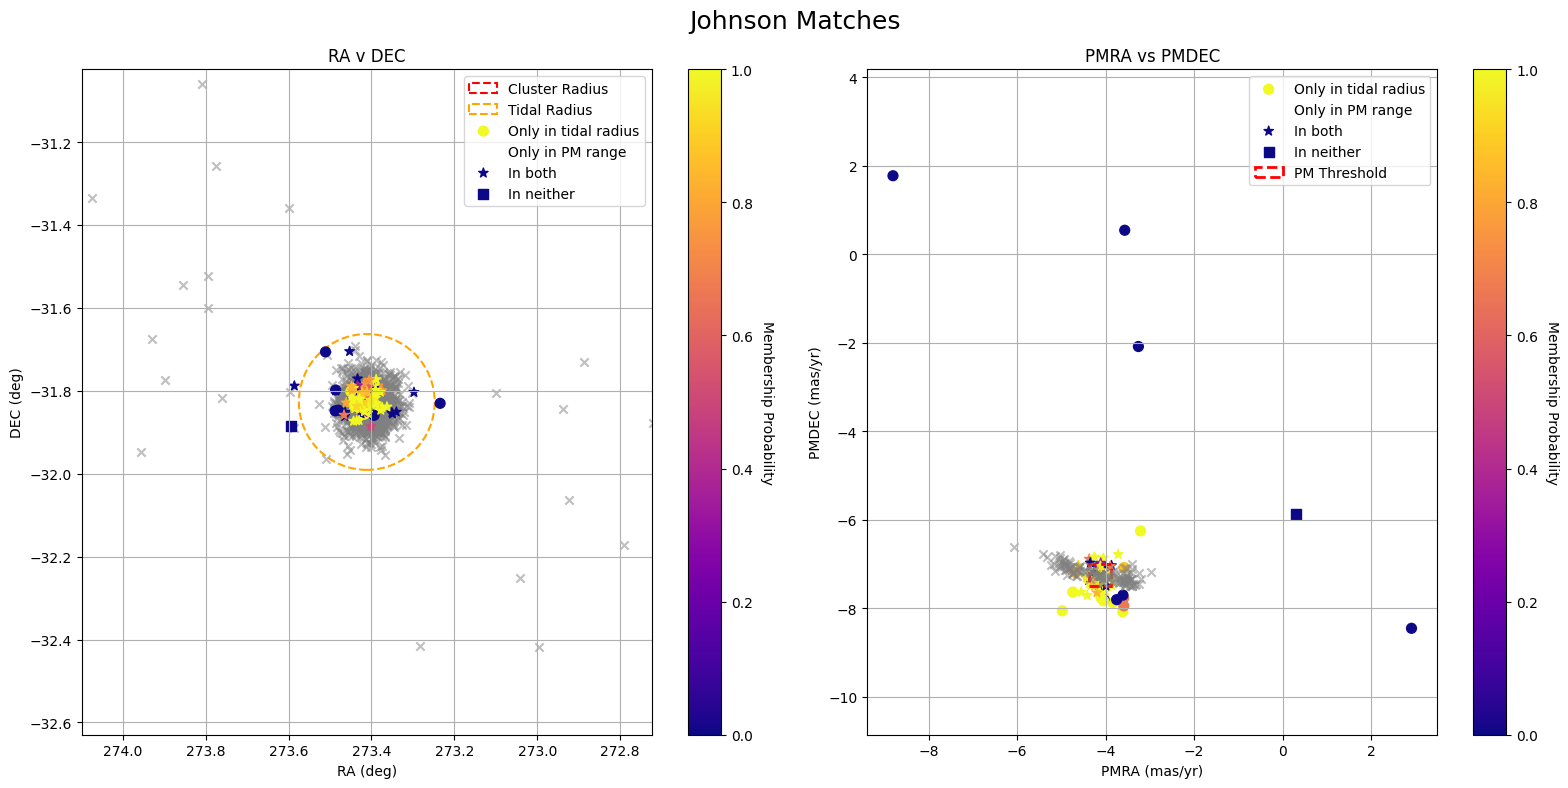

No. of high probability stars: 74 out of 98 total stars


In [10]:
# Start with an RA v DEC plot of one dataset
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Johnson Matches', fontsize=18)

# Set limits for plotting positions
dec_min, dec_max = np.min(observed_probs_df['decdeg']), np.max(observed_probs_df['decdeg']) 
ra_min, ra_max = np.min(observed_probs_df['radeg']), np.max(observed_probs_df['radeg']) 

# Add circles for core and tidal radius to left plot
core_radius = Circle(
    (ra_center, dec_center), core_radius_deg,
    color='red', fill=False, linestyle='--', linewidth=1.5, 
    label='Cluster Radius'
)
ax1.add_patch(core_radius)

tidal_radius = Circle(
    (ra_center, dec_center), tidal_radius_deg,
    color='orange', fill=False, linestyle='--', linewidth=1.5, 
    label='Tidal Radius'
)
ax1.add_patch(tidal_radius)

# Set colormap
cmap = plt.get_cmap('plasma')  
norm = mcolors.Normalize(vmin=0.0, vmax=1.0) 

# Plot Gala stars 
ax1.scatter(gala_stars['RA'], gala_stars['DEC'], marker='x', color='grey', alpha=0.5)

for cat, marker in markers_dict.items():
    # Filter the subset
    subset = Johnson_crossmatches[Johnson_crossmatches['membership_marker'] == cat]
    sc1 = ax1.scatter(
        subset['radeg'], 
        subset['decdeg'],
        c=subset['Gatekeeper Residual'],  # or your membership probability column
        cmap=cmap, 
        norm=norm,
        marker=marker, 
        s=50, 
        alpha=1, 
        label=cat
    )

# Set limits and labels
ax1.set_xlabel('RA (deg)')
ax1.set_ylabel('DEC (deg)')
ax1.set_xlim(ra_max,ra_min)
ax1.set_ylim(dec_min,dec_max)
ax1.set_title('RA v DEC')
ax1.legend(loc='best')
ax1.grid(True)
ax1.set_aspect('equal', adjustable='datalim')

# Add colorbar
cbar1 = plt.colorbar(sc1, ax=ax1)
cbar1.set_label('Membership Probability', rotation=270, labelpad=15)


# Repeat for pmra/pmdec
for cat, marker in markers_dict.items():
    subset = Johnson_crossmatches[Johnson_crossmatches['membership_marker'] == cat]
    sc2 = ax2.scatter(
        subset['pmra'], 
        subset['pmdec'],
        c=subset['Gatekeeper Residual'], 
        cmap=cmap, 
        norm=norm,
        marker=marker, 
        s=50, 
        alpha=1, 
        label=cat
    )

# Add a box to represent the PM threshold
box_size = pm_threshold  
lower_left_x = pmra_center - box_size / 2
lower_left_y = pmdec_center - box_size / 2

box = Rectangle(
    (lower_left_x, lower_left_y), box_size, box_size,
    fill=False,
    edgecolor='red',
    linewidth=2,
    linestyle='--',
    label='PM Threshold'
)
ax2.add_patch(box)

# Plot gala stars
ax2.scatter(gala_stars['PM_RA'], gala_stars['PM_DEC'], marker='x', color='grey', alpha=0.5)

# Limits and labels
ax2.set_xlabel('PMRA (mas/yr)')
ax2.set_ylabel('PMDEC (mas/yr)')
ax2.legend(loc='best')
ax2.set_title('PMRA vs PMDEC')
ax2.grid(True)
ax2.set_aspect('equal', adjustable='datalim')


# Add colorbar 
cbar2 = plt.colorbar(sc2, ax=ax2)
cbar2.set_label('Membership Probability', rotation=270, labelpad=15)

# Plot
plt.tight_layout()
plt.show()

# Check how many stars get assigned a high probability
print(f"No. of high probability stars: {len(np.where(Johnson_crossmatches['Gatekeeper Residual'] >= 0.5)[0])} out of {len(Johnson_crossmatches['Gatekeeper Residual'])} total stars")

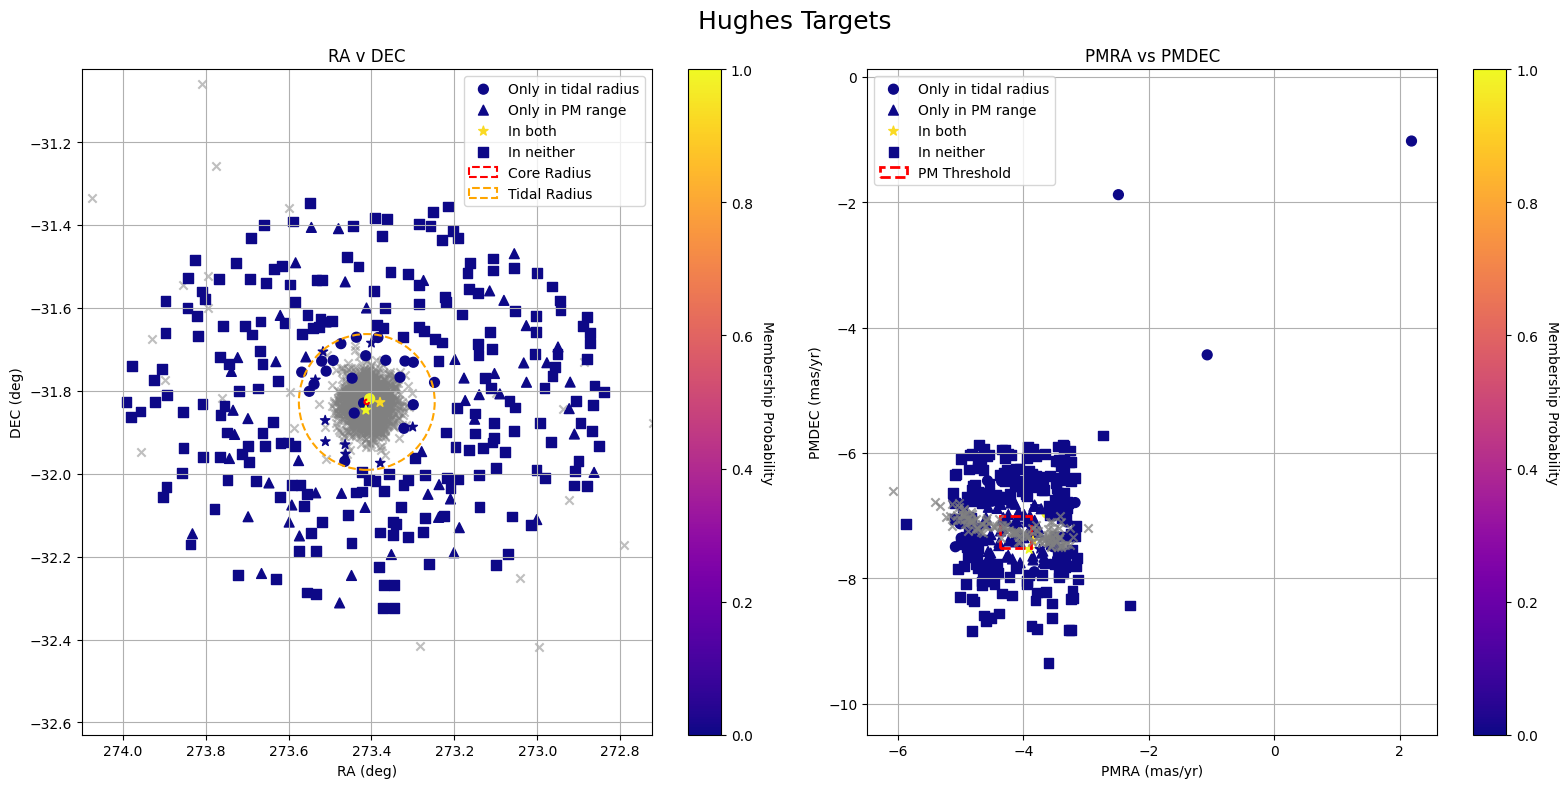

No. of high probability stars: 3 out of 303 total stars


In [11]:
# Repeat for the next dataset
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Hughes Targets', fontsize=18)

dec_min, dec_max = np.min(observed_probs_df['decdeg']), np.max(observed_probs_df['decdeg']) 
ra_min, ra_max = np.min(observed_probs_df['radeg']), np.max(observed_probs_df['radeg']) 

# Set colormap
cmap = plt.get_cmap('plasma')  
norm = mcolors.Normalize(vmin=0.0, vmax=1.0) 

# Plot Gala stars 
ax1.scatter(gala_stars['RA'], gala_stars['DEC'], marker='x', color='grey', alpha=0.5)

for cat, marker in markers_dict.items():
    # Filter the subset
    subset = Hughes_crosstargets[Hughes_crosstargets['membership_marker'] == cat]
    sc1 = ax1.scatter(
        subset['radeg'], 
        subset['decdeg'],
        c=subset['Gatekeeper Residual'],  # or your membership probability column
        cmap=cmap, 
        norm=norm,
        marker=marker, 
        s=50, 
        alpha=1, 
        label=cat
    )

# Add circles for core and tidal radius to ax1
core_radius = Circle(
    (ra_center, dec_center), core_radius_deg,
    color='red', fill=False, linestyle='--', linewidth=1.5, 
    label='Core Radius'
)
ax1.add_patch(core_radius)

tidal_radius = Circle(
    (ra_center, dec_center), tidal_radius_deg,
    color='orange', fill=False, linestyle='--', linewidth=1.5, 
    label='Tidal Radius'
)
ax1.add_patch(tidal_radius)

# Limits and labels
ax1.set_xlabel('RA (deg)')
ax1.set_ylabel('DEC (deg)')
ax1.set_xlim(ra_max,ra_min)
ax1.set_ylim(dec_min,dec_max)
ax1.set_title('RA v DEC')
ax1.legend(loc='best')
ax1.grid(True)
ax1.set_aspect('equal', adjustable='datalim')

# Add colorbar for the left subplot
cbar1 = plt.colorbar(sc1, ax=ax1)
cbar1.set_label('Membership Probability', rotation=270, labelpad=15)


# Repeat for pmra/pmdec
for cat, marker in markers_dict.items():
    subset = Hughes_crosstargets[Hughes_crosstargets['membership_marker'] == cat]
    sc2 = ax2.scatter(
        subset['pmra'], 
        subset['pmdec'],
        c=subset['Gatekeeper Residual'], 
        cmap=cmap, 
        norm=norm,
        marker=marker, 
        s=50, 
        alpha=1, 
        label=cat
    )

# Add a box to represent the PM threshold
box_size = pm_threshold  
lower_left_x = pmra_center - box_size / 2
lower_left_y = pmdec_center - box_size / 2

box = Rectangle(
    (lower_left_x, lower_left_y), box_size, box_size,
    fill=False,
    edgecolor='red',
    linewidth=2,
    linestyle='--',
    label='PM Threshold'
)
ax2.add_patch(box)

# Plot gala stars
ax2.scatter(gala_stars['PM_RA'], gala_stars['PM_DEC'], marker='x', color='grey', alpha=0.75)

# Limits and labels
ax2.set_xlabel('PMRA (mas/yr)')
ax2.set_ylabel('PMDEC (mas/yr)')
ax2.legend(loc='best')
ax2.set_title('PMRA vs PMDEC')
ax2.grid(True)
ax2.set_aspect('equal', adjustable='datalim')

# Add colorbar for the right subplot
cbar2 = plt.colorbar(sc2, ax=ax2)
cbar2.set_label('Membership Probability', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

# Check how many stars get assigned a high probability
print(f"No. of high probability stars: {len(np.where(Hughes_crosstargets['Gatekeeper Residual'] >= 0.5)[0])} out of {len(Hughes_crosstargets['Gatekeeper Residual'])} total stars")

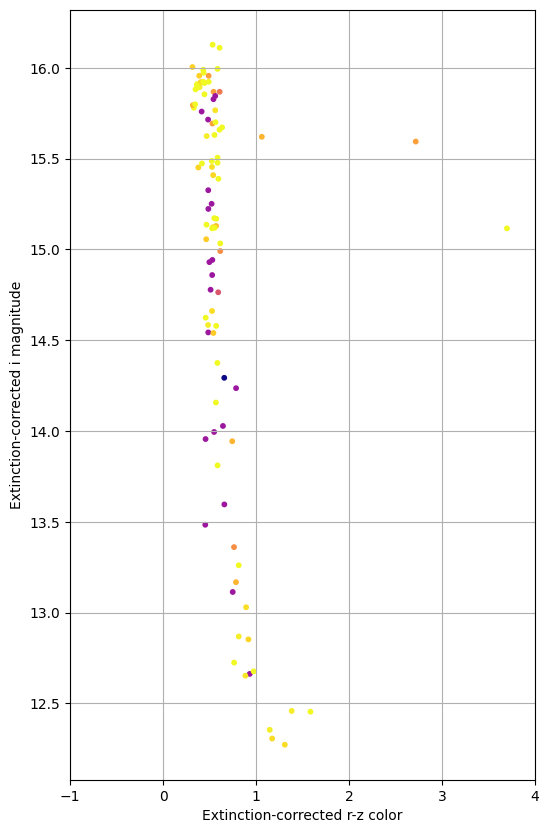

In [12]:
# Plot a CMD of the target stars to check and see if the magnitude limit is why we're losing some
fig,ax = plt.subplots(figsize=(6,10))
plt.scatter((Johnson_crossmatches['rmag'] - Johnson_crossmatches['Ar']) - (Johnson_crossmatches['zmag']-Johnson_crossmatches['Az']),
             (Johnson_crossmatches['imag'] - Johnson_crossmatches['Ai']), c=Johnson_crossmatches['Gatekeeper Residual'], cmap='plasma', s=10)
plt.xlabel('Extinction-corrected r-z color')
plt.ylabel('Extinction-corrected i magnitude')
plt.xlim(-1,4)
plt.grid(True)
plt.show()